# **Import data from kaggel**

In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file
!kaggle datasets download -d andrewmvd/covid19-ct-scans # api copied from kaggle

In [ ]:
!mkdir input

In [ ]:
%cd input

/content/input


In [ ]:
!mkdir covid19-ct-scans

In [ ]:
!unzip /content/covid19-ct-scans.zip -d /content/input/covid19-ct-scans

# **Import libraries**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nibabel as nib

import tensorflow as tf
import keras

#import os
import random

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2 as cv
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, UpSampling2D, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.losses import binary_crossentropy
from keras import backend as K

import tqdm
import pickle
import imgaug as ia
import imgaug.augmenters as iaa

# **load metadata**

In [ ]:
data = pd.read_csv('../input/covid19-ct-scans/metadata.csv')
data.head()

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
4,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


# **Histogram Equalization**

In [ ]:
img_size = 128
clahe = cv.createCLAHE(clipLimit=3.0)

def clahe_enhancer(img, clahe, axes):
    '''Contract Limited Adaptive Histogram Equalizer'''
    img = np.uint8(img*255)  
    clahe_img = clahe.apply(img)

    if len(axes) > 0 :    
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(clahe_img, cmap='bone')
        axes[1].set_title("CLAHE Enhanced CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])

        if len(axes) > 2 :
            axes[2].hist(img.flatten(), alpha=0.4, label='Original CT scan')
            axes[2].hist(clahe_img.flatten(), alpha=0.4, label="CLAHE Enhanced CT scan")
            plt.legend()
        
    return(clahe_img)

Number of slices:  301


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


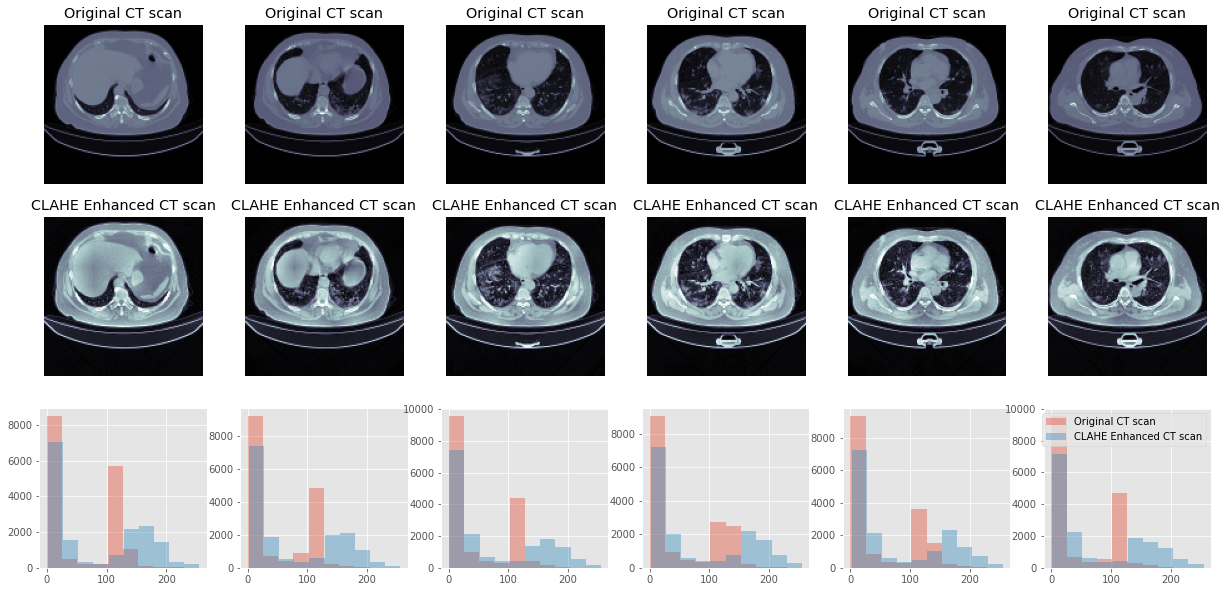

In [ ]:
cts = nib.load(data.loc[0, 'ct_scan'])
slices = cts.shape[2]
print('Number of slices: ', slices)
    
arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]

#np.moveaxis
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(21,10))    

for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, ii]))

# **Crop image**

In [ ]:
def get_contours(img):
    img = np.uint8(img*255)
    
    kernel = np.ones((3,3),np.float32)/9
    img = cv.filter2D(img, -1, kernel)
    
    ret, thresh = cv.threshold(img, 50, 255, cv.THRESH_BINARY)
    contours, hierarchy = cv.findContours(thresh, 2, 1)
    #Areas = [cv.contourArea(cc) for cc in contours]; print(Areas)
    
    size = get_size(img)
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours
    

def get_size(img):
    ih, iw = img.shape
    return iw * ih

def contourOK(cc, size):
    x, y, w, h = cv.boundingRect(cc)
    if ((w < 50 and h > 150) or (w > 150 and h < 50)) : 
        return False # too narrow or wide is bad
    area = cv.contourArea(cc)
    return area < (size * 0.5) and area > 200

def find_boundaries(img, contours):
    ih, iw = img.shape
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0

    for cc in contours:
        x, y, w, h = cv.boundingRect(cc)
        if x < minx: minx = x
        if y < miny: miny = y
        if x + w > maxx: maxx = x + w
        if y + h > maxy: maxy = y + h

    return (minx, miny, maxx, maxy)

def crop_(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]
    
def crop_img(img, axes) :
    contours = get_contours(img)
    #plt.figure() # uncomment to troubleshoot
    #canvas = np.zeros_like(img)
    #cv.drawContours(canvas , contours, -1, (255, 255, 0), 1)
    #plt.imshow(canvas)
    bounds = find_boundaries(img, contours)
    cropped_img = crop_(img, bounds)

    if len(axes) > 0 :
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])
        
        axes[1].imshow(cropped_img, cmap='bone')
        axes[1].set_title("Cropped CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        
    return cropped_img, bounds

Number of slices:  301


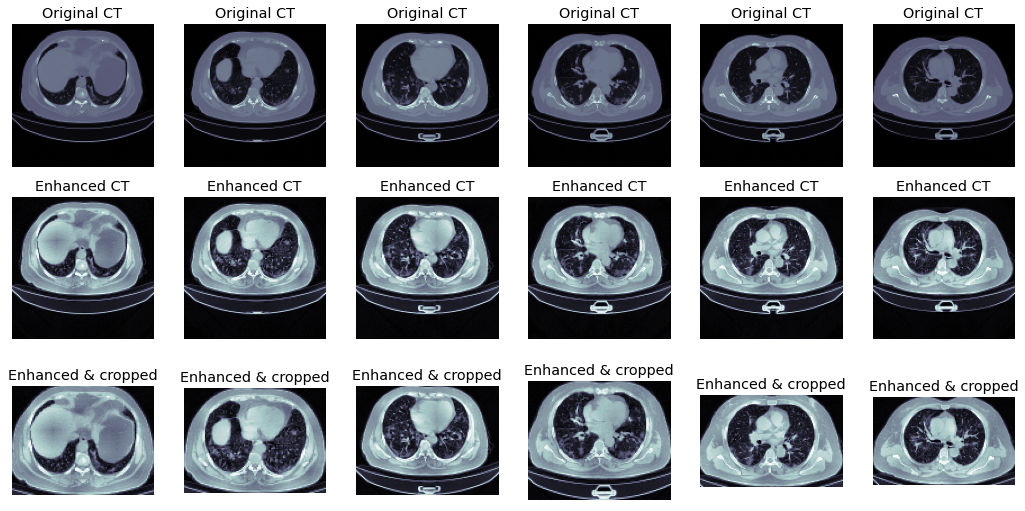

In [ ]:
cts = nib.load(data.loc[0, 'ct_scan'])
slices = cts.shape[2]
print('Number of slices: ', slices)
    
arr = cts.get_fdata()
arr = np.rot90(arr)
arr = arr[:,:,range(90,200,20)]

#np.moveaxis
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(18,9))    

for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    axes[0,ii].imshow(img, cmap='bone')
    axes[0,ii].set_title('Original CT')
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    clahe_img = clahe_enhancer(img, clahe, [])
    axes[1,ii].imshow(clahe_img, cmap='bone')
    axes[1,ii].set_title('Enhanced CT')
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])
    
    _, bounds = crop_img(img, [])
    cropped_img = crop_(clahe_img, bounds)
    axes[2,ii].imshow(cropped_img, cmap='bone')
    axes[2,ii].set_title('Enhanced & cropped')
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])


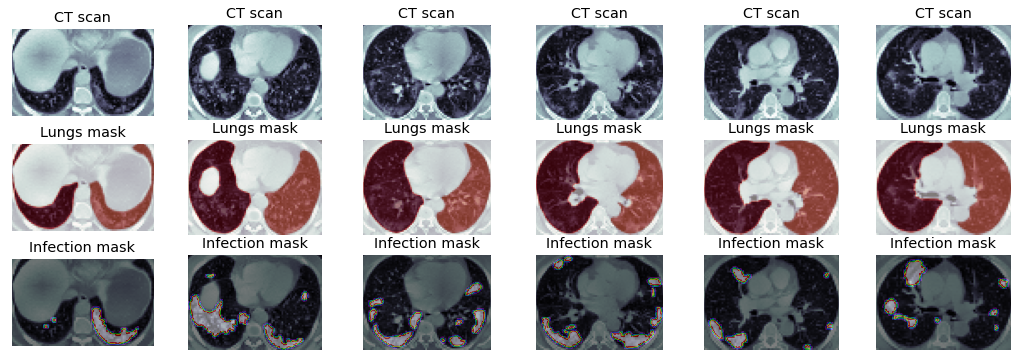

In [ ]:
cts = nib.load(data.loc[0, 'ct_scan'])
lungs = nib.load(data.loc[0, 'lung_mask'])
infec = nib.load(data.loc[0, 'infection_mask'])
slices = cts.shape[2]
    
arr_cts = cts.get_fdata()
arr_lungs = lungs.get_fdata()
arr_infec = infec.get_fdata()

arr_cts = np.rot90(arr_cts)
arr_lungs = np.rot90(arr_lungs)
arr_infec = np.rot90(arr_infec)

arr_cts = arr_cts[:, :, range(92,200,20)]
arr_lungs = arr_lungs[:, :, range(92,200,20)]
arr_infec = arr_infec[:, :, range(92,200,20)]

#np.moveaxis
arr_cts = np.reshape(np.rollaxis(arr_cts, 2), (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
arr_infec = np.reshape(np.rollaxis(arr_infec, 2), (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(18,6))    

for ii in range(arr_cts.shape[0]):
    img_ct = cv.resize(arr_cts[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    img_lungs = cv.resize(arr_lungs[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    img_infec = cv.resize(arr_infec[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

    xmax, xmin = img_lungs.max(), img_lungs.min()
    img_lungs = (img_lungs - xmin)/(xmax - xmin)
    cropped_lungs, bounds = crop_img(img_lungs, [])
    
    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cropped_ct = crop_(clahe_ct, bounds)
    cropped_infec = crop_(img_infec, bounds)
    
    axes[0,ii].imshow(cropped_ct, cmap='bone')
    axes[0,ii].set_title("CT scan")
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    axes[1,ii].imshow(cropped_ct, cmap='bone')
    axes[1,ii].imshow(cropped_lungs, alpha = 0.5, cmap='Reds')
    axes[1,ii].set_title("Lungs mask")
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])

    axes[2,ii].imshow(cropped_ct, cmap='bone')
    axes[2,ii].imshow(cropped_infec, alpha = 0.5, cmap = 'nipy_spectral')
    axes[2,ii].set_title("Infection mask")
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

# **Load all the data**

In [ ]:
cts_all = []
#lungs_all = []
infects_all = []
max_w, max_h = 0, 0 #max width and height

for fnum in tqdm.tqdm(range(20)) : #range(metadata.shape[0])) :
    cts = nib.load(data.loc[fnum, 'ct_scan'])
    lungs = nib.load(data.loc[fnum, 'lung_mask'])
    infec = nib.load(data.loc[fnum, 'infection_mask'])
    
    slices = cts.shape[2]

    arr_cts = cts.get_fdata()
    arr_lungs = lungs.get_fdata()
    arr_infec = infec.get_fdata()

    arr_cts = np.rot90(arr_cts)
    arr_lungs = np.rot90(np.array(arr_lungs))
    arr_infec = np.rot90(arr_infec)

    arr_cts = arr_cts[:, :, round(slices*0.2):round(slices*0.8)]
    arr_lungs = arr_lungs[:, :, round(slices*0.2):round(slices*0.8)]
    arr_infec = arr_infec[:, :, round(slices*0.2):round(slices*0.8)]

    arr_cts = np.reshape(np.rollaxis(arr_cts, 2), (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
    arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
    arr_infec = np.reshape(np.rollaxis(arr_infec, 2), (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))
    
    for ii in range(arr_cts.shape[0]):
    
        img_lungs = cv.resize(arr_lungs[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
        xmax, xmin = img_lungs.max(), img_lungs.min()
        img_lungs = (img_lungs - xmin)/(xmax - xmin)
        cropped_lungs, bounds = crop_img(img_lungs, [])
        #lungs_all.append(cropped_lungs)
        

        h, w = cropped_img.shape
        max_h, max_w = max(max_h, h), max(max_w, w)

        img_ct = cv.resize(arr_cts[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
        xmax, xmin = img_ct.max(), img_ct.min()
        img_ct = (img_ct - xmin)/(xmax - xmin)
        clahe_ct = clahe_enhancer(img_ct, clahe, [])
        cropped_ct = crop_(clahe_ct, bounds)
        cts_all.append(cropped_ct)

        img_infec = cv.resize(arr_infec[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
        cropped_infec = crop_(img_infec, bounds)
        infects_all.append(cropped_infec)

100%|██████████| 20/20 [02:26<00:00,  7.32s/it]


In [ ]:
print("total number of ct slices:",len(cts_all))

total number of ct slices: 2112


**Resize and reshape**

In [ ]:
num_pix = 128
del_lst = []
for ii in tqdm.tqdm(range(len(cts_all))) :
    try :
        cts_all[ii] = cv.resize(cts_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        cts_all[ii] = np.reshape(cts_all[ii], (num_pix, num_pix, 1))

        #lungs_all[ii] = cv.resize(lungs_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        #lungs_all[ii] = np.reshape(lungs_all[ii], (num_pix, num_pix, 1))

        infects_all[ii] = cv.resize(infects_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        infects_all[ii] = np.reshape(infects_all[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)
        
for idx in del_lst[::-1] :
    del cts_all[idx]
    #del lungs_all[idx]
    del infects_all[idx]


100%|██████████| 2112/2112 [00:00<00:00, 11687.83it/s]


In [ ]:
print("total number of slices that must be deleted: ",len(del_lst))

total number of slices that must be deleted:  45


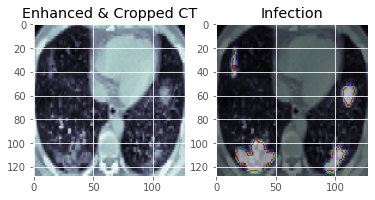

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6,3))

slice_id = 1050
axes[0].imshow(cts_all[slice_id][:, :, 0], cmap='bone')
axes[0].set_title("Enhanced & Cropped CT")

#axes[1].imshow(lungs_all[slice_id][:, :, 0], cmap='Greens')
#axes[1].set_title("Lungs")

axes[1].imshow(cts_all[slice_id][:, :, 0], cmap='bone')
axes[1].imshow(infects_all[slice_id][:, :, 0], alpha = 0.5, cmap = 'nipy_spectral')
axes[1].set_title("Infection");

# **saving the preprocessed data**

In [ ]:
with open('preprocessed_cts.cp', 'wb') as myfile:
    pickle.dump({'cts_all': cts_all, 'infects_all': infects_all}, myfile)
    #print(cts_all)

In [ ]:
%cp "/content/input/preprocessed_cts.cp" "/content/drive/MyDrive/Colab Notebooks/Covid-19 U-Net/just dice 512*512/"

In [ ]:
infect_bool = np.ones((1, len(infects_all)))
for ii in range(len(infects_all)):
    if np.unique(infects_all[ii]).size == 1:
        infect_bool[0, ii] = 0
        
print("Number of CTs with no infection: %d" %(len(infects_all)-infect_bool.sum()))

Number of CTs with no infection: 474


# **Data augmentation**

In [ ]:
ia.seed(1)

seq = iaa.Sequential([
    #iaa.Fliplr(0.5), # horizontal flips
    #iaa.Flipud(0.5), # vertical flips
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-15, 15),
        shear=(-15, 15)
    )
], random_order=True) # apply augmenters in random order

In [ ]:
num_augs = round(len(cts_all)/2.)
rand_idx = np.random.randint(0, len(cts_all), size=num_augs)

sample_cts = [cts_all[ii] for ii in rand_idx]
#sample_lungs = [lungs_all[ii] for ii in rand_idx]
sample_infects = [infects_all[ii] for ii in rand_idx]

In [ ]:
seq_det = seq.to_deterministic()
cts_aug = seq_det.augment_images(sample_cts)
#lungs_aug = seq_det.augment_images(sample_lungs)
infects_aug = seq_det.augment_images(sample_infects)

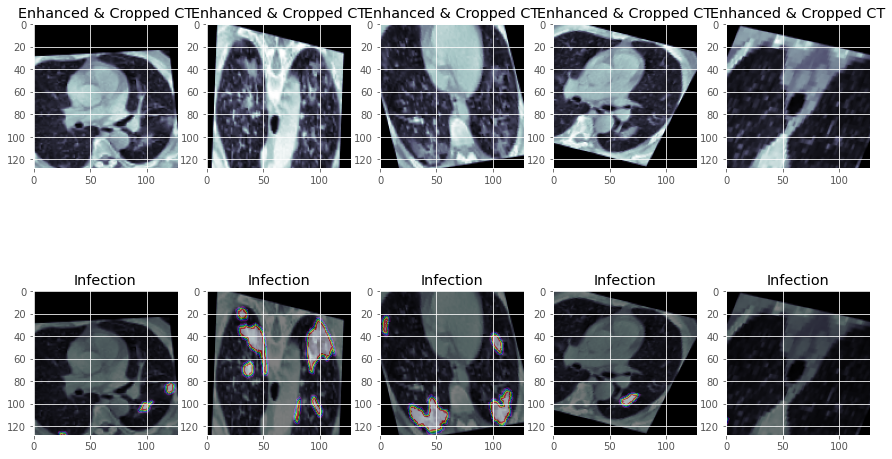

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15,9))

for ii in range(5) :
    axes[0, ii].imshow(cts_aug[ii*10+50][:, :, 0], cmap='bone')
    axes[0, ii].set_title("Enhanced & Cropped CT")

    #axes[1, ii].imshow(lungs_aug[ii*10+50][:, :, 0], cmap='Greens')
    #axes[1, ii].set_title("Lungs")

    axes[1, ii].imshow(cts_aug[ii*10+50][:, :, 0], cmap='bone')
    axes[1, ii].imshow(infects_aug[ii*10+50][:, :, 0], alpha = 0.5, cmap = 'nipy_spectral')
    axes[1, ii].set_title("Infection")

**Pool augmented data and convert it**

In [ ]:
cts_all = tf.convert_to_tensor(cts_all)
cts_aug = tf.convert_to_tensor(cts_aug)
#lungs_all = tf.convert_to_tensor(lungs_all)
#lungs_aug = tf.convert_to_tensor(lungs_aug)
infects_all = tf.convert_to_tensor(infects_all)
infects_aug = tf.convert_to_tensor(infects_aug)

cts = tf.concat([cts_all, cts_aug], axis=0)
#lungs = tf.concat([lungs_all, lungs_aug], axis=0)
infects = tf.concat([infects_all, infects_aug], axis=0)

In [ ]:
indices = tf.range(start=0, limit=cts.shape[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)
                       
cts = tf.gather(cts, shuffled_indices)
#lungs = tf.gather(lungs, shuffled_indices)
infects = tf.gather(infects, shuffled_indices)

print("ct shape: ", cts.shape," and the infects mask shape: ", infects.shape)

ct shape:  (3101, 128, 128, 1)  and the infects mask shape:  (3101, 128, 128, 1)


# **Saving the augmented data**

In [ ]:
with open('augmented_cts.cp', 'wb') as myfile:
    pickle.dump({'cts': cts, 'infects': infects}, myfile)

In [ ]:
%cp "/content/input/augmented_cts.cp" "/content/drive/MyDrive/Colab Notebooks/Covid-19 U-Net/just dice 512*512/"

**plot to test some data**

In [ ]:
def plot_cts_infects(ct, infect, axes) :

    axes[0].imshow(ct[:,:,0], cmap='bone')
    axes[0].set_title('CT image')

    axes[1].imshow(ct[:,:,0], cmap='bone')
    axes[1].imshow(infect[:,:,0], alpha=0.5, cmap='nipy_spectral')
    axes[1].set_title('Infection')

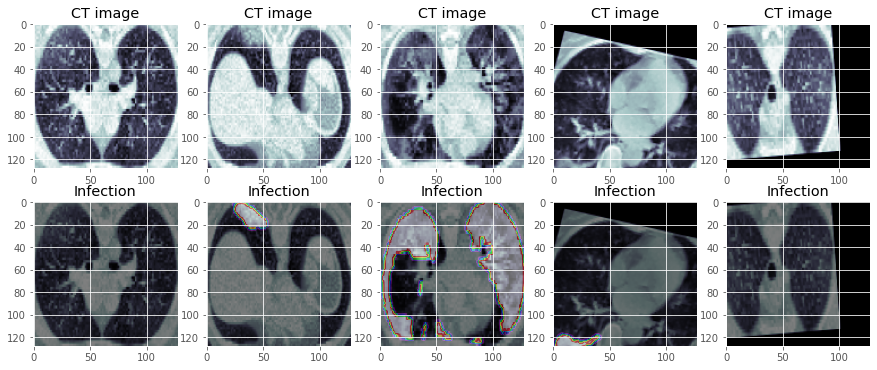

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15,6))

for ii, idx in enumerate(range(150, 350, 40)) :
    plot_cts_infects(cts[idx], infects[idx], list(axes[:,ii]))

# **split data into trainset, testset, validationset**

In [ ]:
train_size = int(0.8*cts.shape[0])
test_size = int(0.1*cts.shape[0])

Xct_train, yinfect_train = (cts[:train_size]/255, infects[:train_size])

Xct_valid, yinfect_valid = (cts[train_size:train_size+test_size]/255, infects[train_size:train_size+test_size])

Xct_test, yinfect_test = (cts[train_size+test_size:]/255, infects[train_size+test_size:])

print("train set size: ", Xct_train.shape, yinfect_train.shape)
print("validation set size: ", Xct_valid.shape, yinfect_valid.shape)
print("test set size: ", Xct_test.shape, yinfect_test.shape)

train set size:  (2480, 128, 128, 1) (2480, 128, 128, 1)
validation set size:  (310, 128, 128, 1) (310, 128, 128, 1)
test set size:  (311, 128, 128, 1) (311, 128, 128, 1)


# **Define loss function and metrics**

**weighted_dice_loss:**

In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f**2) + K.sum(y_pred_f**2) + smooth)
    return 1.0 - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#def bce_logdice_loss(y_true, y_pred):
#    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

'''
def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss
'''

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

**surfaceloss:**

In [ ]:
from scipy.ndimage import distance_transform_edt as distance


def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true):
    y_true_numpy = y_true
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)


def surface_loss_keras(y_true, y_pred):
    y_true_dist_map = tf.compat.v1.py_func(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)

sum them up:

In [ ]:
def gl_sl_wrapper(alpha):
    def gl_sl(y_true, y_pred):
        return alpha* weighted_bce_dice_loss(y_true, y_pred) +  (1-alpha)* surface_loss_keras(y_true, y_pred)
    return gl_sl

In [ ]:
from keras.callbacks import ModelCheckpoint, Callback

class AlphaScheduler(Callback):
  def init(self, alpha, update_fn):
    self.alpha = alpha
    self.update_fn = update_fn
  def on_epoch_end(self, epoch, logs=None):
    updated_alpha = self.update_fn(K.get_value(self.alpha))

alpha = K.variable(1, dtype='float32')

def update_alpha(value):
  return np.clip(value - 0.01, 0.01, 1)

**Other Metrics:**

In [ ]:
def dice_coef(y_true, y_pred, smooth = 1.0):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

In [ ]:
def iou(y_true, y_pred, smooth = 0.0001):
  intersection = K.sum(y_true * y_pred)
  sum_ = K.sum(y_true + y_pred)
  jac = (intersection + smooth) / (sum_ - intersection + smooth)
  return jac

# **Define Unet**

In [ ]:
def unet(input_size=(128,128,1), dfilters=64, ufilters=64, dropout_rate=0.5):
    inputs = Input(input_size)
    
    conv1 = Conv2D(dfilters,kernel_size=(3,3),strides=(1,1),padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(dfilters,kernel_size=(3,3),strides=(1,1),padding='same')(bn1)
    bn1 = Activation('relu')(conv1)
    pool1=MaxPooling2D((2,2))(bn1)
    ################################################################################
    conv2 = Conv2D(dfilters*2,kernel_size=(3,3),strides=(1,1),padding='same')(pool1)
    bn2 = BatchNormalization()(conv2)
    bn2 = Activation('relu')(bn2)
    conv2 = Conv2D(dfilters*2,kernel_size=(3,3),strides=(1,1),padding='same')(bn2)
    bn2 = BatchNormalization()(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D((2,2))(bn2)
    ################################################################################
    conv3 = Conv2D(dfilters*4,kernel_size=(3,3),strides=(1,1),padding='same')(pool2)
    bn3 = BatchNormalization()(conv3)
    bn3 = Activation('relu')(bn3)
    conv3 = Conv2D(dfilters*4,kernel_size=(3,3),strides=(1,1),padding='same')(bn3)
    bn3 = BatchNormalization()(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D((2,2))(bn3)
    ################################################################################
    conv4 = Conv2D(dfilters*8,kernel_size=(3,3),strides=(1,1),padding='same')(pool3)
    bn4 = BatchNormalization()(conv4)
    bn4 = Activation('relu')(bn4)
    conv4 = Conv2D(dfilters*8,kernel_size=(3,3),strides=(1,1),padding='same')(bn4)
    bn4 = BatchNormalization()(conv4)
    bn4 = Activation('relu')(bn4)
    bn4 = Dropout(dropout_rate)(bn4)
    pool4 = MaxPooling2D((2,2))(bn4)
    ################################################################################
    conv5 = Conv2D(dfilters*16,kernel_size=(3,3),strides=(1,1),padding='same')(pool4)
    bn5 = BatchNormalization()(conv5)
    bn5 = Activation('relu')(bn5)
    conv5 = Conv2D(dfilters*16,kernel_size=(3,3),strides=(1,1),padding='same')(bn5)
    bn5 = BatchNormalization()(conv5)
    bn5 = Activation('relu')(bn5)
    bn5 = Dropout(dropout_rate)(bn5)
    ################################################################################
    up6 = UpSampling2D((2,2))(bn5)
    conv6 = Conv2D(dfilters*8,kernel_size=(3,3),strides=(1,1),padding='same')(up6)
    bn6 = BatchNormalization()(conv6)
    bn6 = Activation('relu')(bn6)
    
    atb_g6 = Conv2D(ufilters*8,kernel_size=(1,1),strides=(1,1),padding='valid')(bn6)
    atb_g6 = BatchNormalization()(atb_g6)
    atb_x6 = Conv2D(ufilters*8,kernel_size=(1,1),strides=(1,1),padding='valid')(bn4)
    atb_x6 = BatchNormalization()(atb_x6)
    psi6 = Add()([atb_g6,atb_x6])
    psi6 = Activation('relu')(psi6)
    psi6 = Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi6)
    psi6 = BatchNormalization()(psi6)
    conv6 = Activation('sigmoid')(psi6)
    
    up6 = Concatenate()([up6,conv6])
    
    conv6 = Conv2D(ufilters*8,kernel_size=(3,3),strides=(1,1),padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(ufilters*8,kernel_size=(3,3),strides=(1,1),padding='same')(bn6)
    bn6 = Activation('relu')(conv6)
    ################################################################################
    up7 = UpSampling2D((2,2))(bn6)
    conv7 = Conv2D(dfilters*4,kernel_size=(3,3),strides=(1,1),padding='same')(up7)
    bn7 = BatchNormalization()(conv7)
    bn7 = Activation('relu')(bn7)
    
    atb_g7 = Conv2D(ufilters*4,kernel_size=(1,1),strides=(1,1),padding='valid')(bn7)
    atb_g7 = BatchNormalization()(atb_g7)
    atb_x7 = Conv2D(ufilters*4,kernel_size=(1,1),strides=(1,1),padding='valid')(bn3)
    atb_x7 = BatchNormalization()(atb_x7)
    psi7 = Add()([atb_g7,atb_x7])
    psi7 = Activation('relu')(psi7)
    psi7 = Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi7)
    psi7 = BatchNormalization()(psi7)
    conv7 = Activation('sigmoid')(psi7)
    
    up7 = Concatenate()([up7,conv7])
    
    conv7 = Conv2D(ufilters*4,kernel_size=(3,3),strides=(1,1),padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(ufilters*4,kernel_size=(3,3),strides=(1,1),padding='same')(bn7)
    bn7 = Activation('relu')(conv7)
    ################################################################################
    up8 = UpSampling2D((2,2))(bn7)
    conv8 = Conv2D(dfilters*2,kernel_size=(3,3),strides=(1,1),padding='same')(up8)
    bn8 = BatchNormalization()(conv8)
    bn8 = Activation('relu')(bn8)
    
    atb_g8 = Conv2D(ufilters*2,kernel_size=(1,1),strides=(1,1),padding='valid')(bn8)
    atb_g8 = BatchNormalization()(atb_g8)
    atb_x8 = Conv2D(ufilters*2,kernel_size=(1,1),strides=(1,1),padding='valid')(bn2)
    atb_x8 = BatchNormalization()(atb_x8)
    psi8 = Add()([atb_g8,atb_x8])
    psi8 = Activation('relu')(psi8)
    psi8 = Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi8)
    psi8 = BatchNormalization()(psi8)
    conv8 = Activation('sigmoid')(psi8)
    
    up8 = Concatenate()([up8,conv8])
    
    conv8 = Conv2D(ufilters*2,kernel_size=(3,3),strides=(1,1),padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(ufilters*2,kernel_size=(3,3),strides=(1,1),padding='same')(bn8)
    bn8 = Activation('relu')(conv8)
    ################################################################################
    up9 = UpSampling2D((2,2))(bn8)
    conv9 = Conv2D(dfilters,kernel_size=(3,3),strides=(1,1),padding='same')(up9)
    bn9 = BatchNormalization()(conv9)
    bn9 = Activation('relu')(bn9)
    
    atb_g9 = Conv2D(ufilters,kernel_size=(1,1),strides=(1,1),padding='valid')(bn9)
    atb_g9 = BatchNormalization()(atb_g9)
    atb_x9 = Conv2D(ufilters,kernel_size=(1,1),strides=(1,1),padding='valid')(bn1)
    atb_x9 = BatchNormalization()(atb_x9)
    psi9 = Add()([atb_g9,atb_x9])
    psi9 = Activation('relu')(psi9)
    psi9 = Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi9)
    psi9 = BatchNormalization()(psi9)
    conv9 = Activation('sigmoid')(psi9)
    
    up9 = Concatenate()([up9,conv9])
    
    conv9 = Conv2D(ufilters,kernel_size=(3,3),strides=(1,1),padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(ufilters,kernel_size=(3,3),strides=(1,1),padding='same')(bn9)
    bn9 = Activation('relu')(conv9)
    ################################################################################
    outputs = Conv2D(1,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(bn9)
    
    model = Model(inputs=inputs,outputs=outputs)
    
    return model

# **Compile and fit the model**

In [ ]:
weight_path="{}_weights.augmenteddicesurface.hdf5".format('model')
checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

In [ ]:
BATCH_SIZE = 32
learning_rate = 1e-4
EPOCHS = 50

In [ ]:
model = unet(input_size=(img_size, img_size, 1))

decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=gl_sl_wrapper(alpha), metrics=[dice_coef, iou])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
#callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(Xct_train, yinfect_train, epochs=EPOCHS,
                    validation_data = (Xct_valid, yinfect_valid),
                    callbacks=[checkpoint])

Epoch 1/50
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
78/78 [==============================] - 71s 709ms/step - loss: 0.9836 - dice_coef: 0.1299 - iou: 0.1096 - val_loss: 1.4108 - val_dice_coef: 0.0325 - val_iou: 0.0220

Epoch 00001: val_dice_coef improved from -inf to 0.03255, saving model to model_weights.augmenteddicesurface.hdf5
Epoch 2/50
78/78 [=================

In [ ]:
history = model.fit(Xct_train, yinfect_train, epochs=EPOCHS,
                    validation_data = (Xct_valid, yinfect_valid),
                    callbacks=[checkpoint])

Epoch 1/50
78/78 [==============================] - 50s 644ms/step - loss: 0.0703 - dice_coef: 0.7603 - iou: 0.7542 - val_loss: 0.1630 - val_dice_coef: 0.5835 - val_iou: 0.6473

Epoch 00001: val_dice_coef did not improve from 0.65560
Epoch 2/50
78/78 [==============================] - 49s 633ms/step - loss: 0.0684 - dice_coef: 0.7633 - iou: 0.7575 - val_loss: 0.1530 - val_dice_coef: 0.6348 - val_iou: 0.6703

Epoch 00002: val_dice_coef did not improve from 0.65560
Epoch 3/50
78/78 [==============================] - 50s 642ms/step - loss: 0.0670 - dice_coef: 0.7658 - iou: 0.7585 - val_loss: 0.1491 - val_dice_coef: 0.6588 - val_iou: 0.6757

Epoch 00003: val_dice_coef improved from 0.65560 to 0.65875, saving model to model_weights.augmenteddicesurface.hdf5
Epoch 4/50
78/78 [==============================] - 50s 638ms/step - loss: 0.0671 - dice_coef: 0.7653 - iou: 0.7593 - val_loss: 0.1536 - val_dice_coef: 0.6487 - val_iou: 0.6703

Epoch 00004: val_dice_coef did not improve from 0.65875
Epo

# **Evaluation**

In [ ]:
weight_path = "/content/input/model_weights.augmenteddicesurface.hdf5"

In [ ]:
model.load_weights(weight_path)
model.save('model_dice_surface_aug.h5') 

In [ ]:
%cp "/content/input/model_dice_surface_aug.h5" "/content/drive/MyDrive/Colab Notebooks/Covid-19 U-Net/just dice 512*512/"
%cp "/content/input/model_weights.augmenteddicesurface.hdf5" "/content/drive/MyDrive/Colab Notebooks/Covid-19 U-Net/just dice 512*512/"

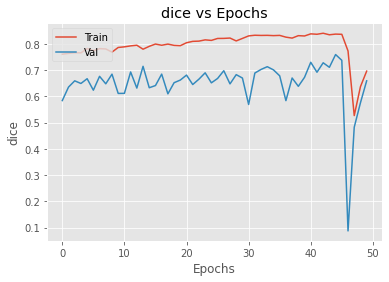

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('dice vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('dice')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

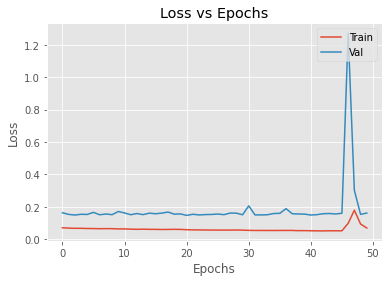

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc = 'upper right')
plt.show()

**Test set evaluation**

In [ ]:
len(Xct_test)

311

In [ ]:
predicted_test = model.predict(Xct_test)

In [ ]:
threshold = 0.7

# use threshold to get hard predictions
predicted_test[predicted_test > threshold] = 1.0
predicted_test[predicted_test <= threshold] = 0.0

Text(0.5, 1.0, 'predicted infection mask')

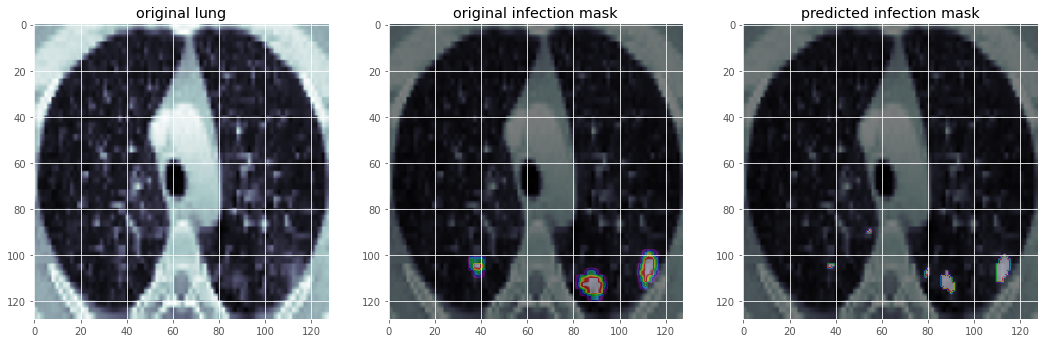

In [ ]:
fig = plt.figure(figsize = (18,15))

image_id_test = 70
plt.subplot(1,3,1)
plt.imshow(Xct_test[image_id_test][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,3,2)
plt.imshow(Xct_test[image_id_test][...,0], cmap = 'bone')
plt.imshow(yinfect_test[image_id_test][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(Xct_test[image_id_test][...,0], cmap = 'bone')
plt.imshow(predicted_test[image_id_test][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

**train set evaluation**

In [ ]:
len(Xct_train)

2480

In [ ]:
predicted_train = model.predict(Xct_train)

In [ ]:
threshold = 0.7

# use threshold to get hard predictions
predicted_train[predicted_train > threshold] = 1.0
predicted_train[predicted_train <= threshold] = 0.0

Text(0.5, 1.0, 'predicted infection mask')

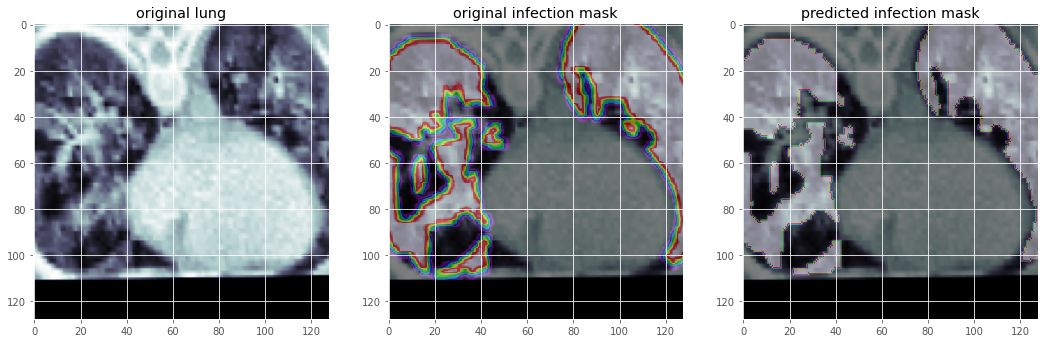

In [ ]:
fig = plt.figure(figsize = (18,15))

image_id_test = 600
plt.subplot(1,3,1)
plt.imshow(Xct_train[image_id_test][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,3,2)
plt.imshow(Xct_train[image_id_test][...,0], cmap = 'bone')
plt.imshow(yinfect_train[image_id_test][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(Xct_train[image_id_test][...,0], cmap = 'bone')
plt.imshow(predicted_train[image_id_test][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

**Validation set evaluation**

In [ ]:
len(Xct_valid)

310

In [ ]:
predicted_val = model.predict(Xct_valid)

In [ ]:
threshold = 0.7

# use threshold to get hard predictions
predicted_val[predicted_val > threshold] = 1.0
predicted_val[predicted_val <= threshold] = 0.0

Text(0.5, 1.0, 'predicted infection mask')

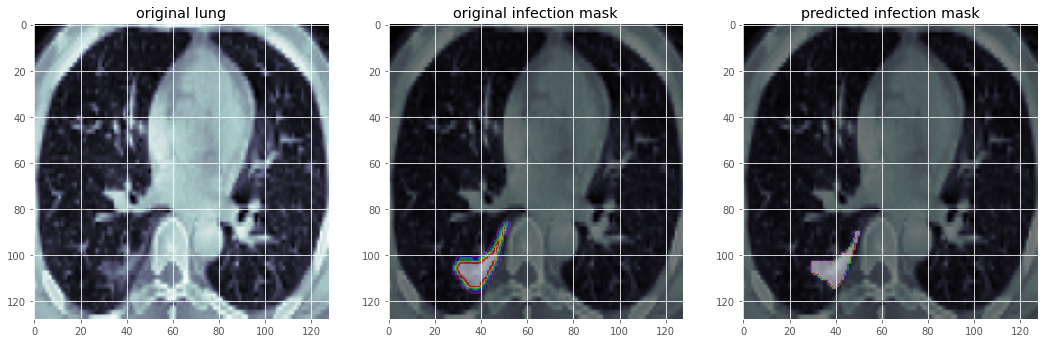

In [ ]:
fig = plt.figure(figsize = (18,15))

image_id_test = 70
plt.subplot(1,3,1)
plt.imshow(Xct_valid[image_id_test][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,3,2)
plt.imshow(Xct_valid[image_id_test][...,0], cmap = 'bone')
plt.imshow(yinfect_valid[image_id_test][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(Xct_valid[image_id_test][...,0], cmap = 'bone')
plt.imshow(predicted_val[image_id_test][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

**AUC and sensitivity and specificity**

In [ ]:
def compute_class_sens_spec(pred, label):

    class_pred = pred
    class_label = label
    
    # true positives
    tp = np.sum((class_pred==1) & (class_label==1))

    # true negatives
    tn = np.sum((class_pred==0) & (class_label==0))
    
    #false positives
    fp = np.sum((class_pred==1) & (class_label==0))
    
    # false negatives
    fn = np.sum((class_pred==0) & (class_label==1))

    # compute sensitivity and specificity
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    AUC = 1 - ((fp/(fp+tn) + (fn/(fn+tp))))

    return sensitivity, specificity, AUC

In [ ]:
sens_train, spec_train, AUC_train = compute_class_sens_spec(predicted_train, yinfect_train)
sens_val, spec_val, AUC_val = compute_class_sens_spec(predicted_val, yinfect_valid)
sens_test, spec_test, AUC_test = compute_class_sens_spec(predicted_test, yinfect_test)

In [ ]:
patch_metrics = pd.DataFrame(
        columns = ['trainset', 'validationset', 'testset'],
        index = ['Sensitivity','Specificity', 'AUC'])

patch_metrics.loc['Sensitivity', 'trainset'] = sens_train
patch_metrics.loc['Specificity', 'trainset'] = spec_train
patch_metrics.loc['AUC', 'trainset'] = AUC_train

patch_metrics.loc['Sensitivity', 'validationset'] = sens_test
patch_metrics.loc['Specificity', 'validationset'] = spec_test
patch_metrics.loc['AUC', 'validationset'] = AUC_val

patch_metrics.loc['Sensitivity', 'testset'] = sens_test
patch_metrics.loc['Specificity', 'testset'] = spec_test
patch_metrics.loc['AUC', 'testset'] = AUC_test
print(patch_metrics)

             trainset validationset   testset
Sensitivity  0.994627      0.934817  0.934817
Specificity  0.999998      0.998934  0.998934
AUC          0.994625      0.944052  0.933751
